In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import networkx as nx
import matplotlib.pyplot as plt
import pygraphviz
import pydot
from IPython.display import Image

In [2]:
def make_new_node_from_numpy_arr(numpy_array
                                 , time_period = timedelta(minutes=10)
                                 , p_time = 0, p_type = 1, p_from = 2, p_to = 3, p_sn = 5):
    serial_number = 0
    for i in range(len(numpy_array)-1):
        # Check next
        if numpy_array[i+1][p_time] - numpy_array[i][p_time] < time_period:
            numpy_array[i][p_from] = numpy_array[i][p_type] + '_' + str(serial_number)
            numpy_array[i][p_to] = numpy_array[i+ 1][p_type] + '_' + str(serial_number + 1)
            numpy_array[i][p_sn] = serial_number
            serial_number += 1
        else:
            numpy_array[i][p_from] = numpy_array[i][p_type] + '_' + str(serial_number)
            numpy_array[i][p_sn] = serial_number
            serial_number = 0
    if serial_number != 0:
        numpy_array[-1][p_from] = numpy_array[-1][p_type] + '_' + str(serial_number)
        numpy_array[-1][p_sn] = serial_number
        
    return numpy_array


def make_graph_from_dataframe(dataframe, col_list):
    graph_np_array = np.array([col_list])
    for cl in list(dataframe['clients'].unique()):
        tmp_np = dataframe[dataframe['clients'] == cl][col_list].to_numpy()
        tmp_np = make_new_node_from_numpy_arr(tmp_np, TIME_BETWEEN)
        graph_np_array = np.concatenate((graph_np_array, tmp_np))
    return graph_np_array


def make_list_of_number_graphs(graph_np_array, p_serial_num = 5):
    tmp_n = 0
    tmp_list = []
    for i in range(1, len(graph_np_array)):
        if graph_np_array[i][p_serial_num] == 0: 
            tmp_n += 1
        tmp_list.append(tmp_n)
    return tmp_list


def len_node_f(node_from):
    return len(graph_df[(graph_df['from'] == node_from['from']) & (graph_df['resolution_flg'] == 'F')])


def get_color(coef):
    return '#%02x%02x%02x' % (255, int(255 * (1 - coef)), int(255 * (1 - coef)))


def convert_networkx_to_dot_graph(G):
    graph_type = "digraph"
    strict = nx.number_of_selfloops(G) == 0 and not G.is_multigraph()
    graph_defaults = G.graph.get("graph", {})
    P = pydot.Dot("Client sessions", graph_type=graph_type, strict=strict)
    P.set_node_defaults(shape='box', style="filled, rounded", color="black", fontname='helvetica')
    P.set_edge_defaults(fontname='helvetica')

    for n, nodedata in G.nodes(data=True):
        if n != '':
            str_nodedata = {k: str(v) for k, v in nodedata.items()}
            p = pydot.Node(str(n), **str_nodedata)
            P.add_node(p)

    for u, v, edgedata in G.edges(data=True):
        if v != '':
            str_edgedata = {k: str(v) for k, v in edgedata.items()}
            edge = pydot.Edge(str(u), str(v), **str_edgedata)
            P.add_edge(edge)
    return P

## Make dataframe from import data (csv file)

In [3]:
df = pd.read_csv('dataset.csv',sep=';').drop(['Number'], axis=1)
df = df.fillna(value='')
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
df['from'] = ''
df['to'] = ''
df['serial_number'] = 0

COLUMNS_LIST = ['time','type','from','to','resolution_flg','serial_number', 'clients']
TIME_BETWEEN = timedelta(minutes=10)

df.head(1)

,clients,type,time,resolution_flg,from,to,serial_number
0,CL1,SESSION_SIGNIN,2020-10-05 16:30:34,,,,0


## Transform data to the "graph like form" and add new collumns

In [4]:
graph_np = make_graph_from_dataframe(df,COLUMNS_LIST)

graph_df = pd.DataFrame(data=graph_np[1:], columns=graph_np[0])

graph_df['node_count'] = graph_df.groupby('type')['type'].transform('count')
# node attr
graph_df['node_w_order_c'] = graph_df.groupby('from')['from'].transform('count')
graph_df['count_F'] = graph_df.apply(lambda row: len_node_f(row), axis=1) 
# graph_df['count_cl'] = graph_df.groupby('from')['clients'].transform('count')
# edge attr
graph_df['edge_count'] = graph_df.groupby(['from','to'])['type'].transform('count')
# 

graph_df['graph_num'] = make_list_of_number_graphs(graph_np)
f_graph_index = graph_df[graph_df['resolution_flg'] == 'F']['graph_num'].unique().tolist()
graph_df.loc[graph_df['graph_num'].isin(f_graph_index), 'resolution_flg_v2'] = 'F'
graph_df['resolution_flg_v2'] = graph_df['resolution_flg_v2'].fillna(value='')

# graph_df

## Make node attribute dataframe

In [10]:
graph_node_attr = graph_df.loc[graph_df['from'] != ''][['from','node_w_order_c','count_F']].drop_duplicates()
graph_node_attr['prc'] = graph_node_attr['count_F'] / graph_node_attr['node_w_order_c']

graph_node_attr['fillcolor'] = graph_node_attr.apply(lambda row: get_color(row['prc']), axis=1) 
graph_node_attr = pd.merge(graph_node_attr, graph_df[['from','clients']].drop_duplicates().groupby('from')[['clients']].count(), on='from')


graph_node_attr['label'] = graph_node_attr['from'] + \
    '\\nAll ' + graph_node_attr['node_w_order_c'].astype(str) + \
    '\\nFraud ' + graph_node_attr['count_F'].astype(str) + \
    '\\nClients ' + graph_node_attr['clients'].astype(str)

# graph_node_attr

## Create Networkx Graph

In [11]:
G = nx.from_pandas_edgelist(graph_df.loc[graph_df['from'] != ''][['from','to']]
                                    ,source='from'
                                    ,target='to'
                                    ,create_using=nx.DiGraph())
# add node attr
nx.set_node_attributes(G, graph_node_attr[['from','label', 'fillcolor']].set_index('from').to_dict('index'))

## Convert Networkx Graph to Dot file  

In [12]:
P = convert_networkx_to_dot_graph(G)

In [13]:
P.write_png('tmp.png')

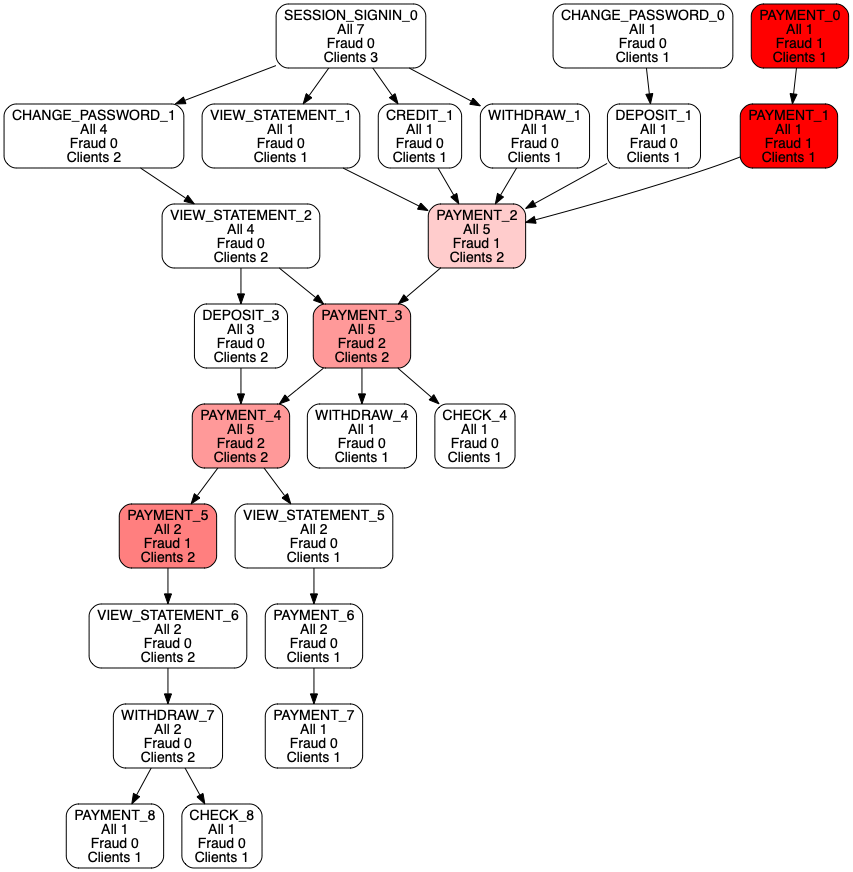

In [14]:
Image('tmp.png')